<a href="https://colab.research.google.com/github/jawahirkhaleel/Jawahir/blob/main/glaciers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U geemap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.1/472.1 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.7 MB/s eta 0:00:00
  Attempting uninstall: earthengine-api
    Found existing installation: earthengine-api 1.5.24
    Uninstalling earthengine-api-1.5.24:
      Successfully uninstalled earthengine-api-1.5.24
  Attempting uninstall: geemap
    Found existing installation: geemap 0.35.3
    Uninstalling geemap-0.35.3:
      Successfully uninstalled geemap-0.35.3


In [4]:
import ee
import geemap

ee.Authenticate()
ee.Initialize(project='ee-jawahirkhaleel05') # Replace 'your-project-id' with your actual Google Cloud Project ID.

In [5]:
cor = [
    [75.30079101876035, 35.680003095566235],
    [75.34885620430722, 35.680003095566235],
    [75.34885620430722, 35.73366878981927],
    [75.30079101876035, 35.73366878981927],
    [75.30079101876035, 35.680003095566235]
]

roi = ee.Geometry.Polygon([cor])


In [6]:
Map = geemap.Map()
Map.centerObject(roi, 10)
Map.addLayer(roi, {}, 'ROI')
Map


Map(center=[35.70683532064693, 75.32482361153195], controls=(WidgetControl(options=['position', 'transparent_b…

In [7]:
time_start = '2001-01-01'
time_end   = '2023-12-31'


In [8]:
modis = (
    ee.ImageCollection("MODIS/061/MOD09A1")
    .filterDate(time_start, time_end)
    .filterBounds(roi)
)

def calc_ndwi(img):
    band = img.select('sur_refl_b.*').multiply(0.0001)
    ndwi = band.normalizedDifference(
        ['sur_refl_b04', 'sur_refl_b02']
    ).rename('NDWI')
    return ndwi.copyProperties(img, img.propertyNames())

ndwi = modis.map(calc_ndwi)


In [9]:
ndwi_2010 = ndwi.filterDate('2010-01-01', '2011-12-31').median()

Map.addLayer(
    ndwi_2010.clip(roi),
    {'min': -0.5, 'max': 0.5},
    'NDWI 2010–2011'
)
Map


Map(bottom=51929.0, center=[35.646137228802424, 75.41015625], controls=(WidgetControl(options=['position', 'tr…

In [11]:
hist = geemap.image_histogram(
    ndwi_2010,
    region=roi,
    scale=500
)
hist


ValueError: invalid literal for int() with base 10: '-0.0010841893963515759'

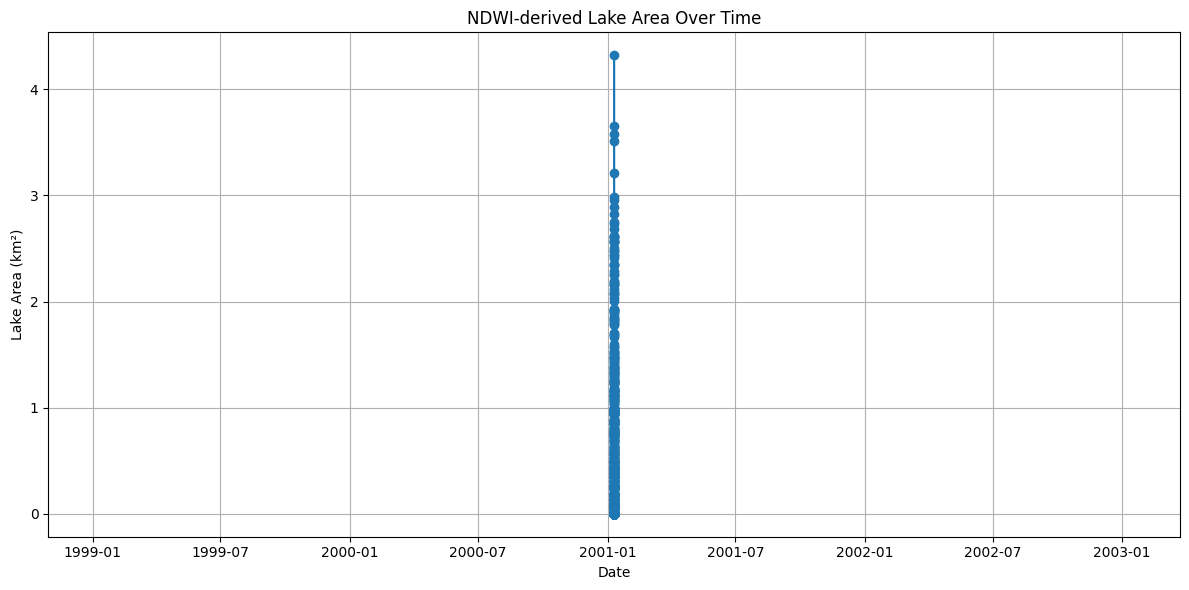

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['area_km2'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Lake Area (km²)')
plt.title('NDWI-derived Lake Area Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# Scale and round the NDWI values to integers for histogramming
# Multiplying by 1000 and rounding allows for more granular integer bins
ndwi_2010_quantized = ndwi_2010.multiply(1000).round().int()


In [13]:
hist_quantized = geemap.image_histogram(
    ndwi_2010_quantized,
    region=roi,
    scale=500
)

# The histogram now shows counts for quantized NDWI values.
# To interpret, remember that a value of X in the histogram corresponds to an original NDWI of X/1000.
hist_quantized

In [14]:
def lake_area(img):
    thr = img.gt(0.1)
    mask = thr.updateMask(thr)
    area = mask.multiply(ee.Image.pixelArea()).divide(1e6)
    return area.copyProperties(img, img.propertyNames())

lake_area_ic = ndwi.map(lake_area)


In [27]:
def area_stats(img):
    area = img.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=roi,
        scale=500,
        maxPixels=1e13
    )
    return ee.Feature(
        None,
        {
            'date': ee.Date(img.get('system:time_start')).format('2001-01-10'),
            'area_km2': area.get('NDWI')
        }
    )

table = lake_area_ic.map(area_stats).filter(ee.Filter.notNull(['area_km2']))


In [35]:
import pandas as pd

df = pd.DataFrame([f['properties'] for f in table.getInfo()['features']])

# Explicit date parsing
df['date'] = pd.to_datetime(df['date'])

df = df.sort_values('date')
df.head()

,area_km2,date
0,1.933499,2001-01-10
695,0.000000,2001-01-10
696,0.578480,2001-01-10
697,0.603972,2001-01-10
698,0.000000,2001-01-10


from matplotlib import pyplot as plt
_df_9['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10['area_km2'].plot(kind='hist', bins=20, title='area_km2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='index', y='area_km2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['area_km2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('area_km2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['area_km2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('area_km2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_16['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['area_km2'].plot(kind='line', figsize=(8, 4), title='area_km2')
plt.gca().spines[['top', 'right']].set_visible(False)

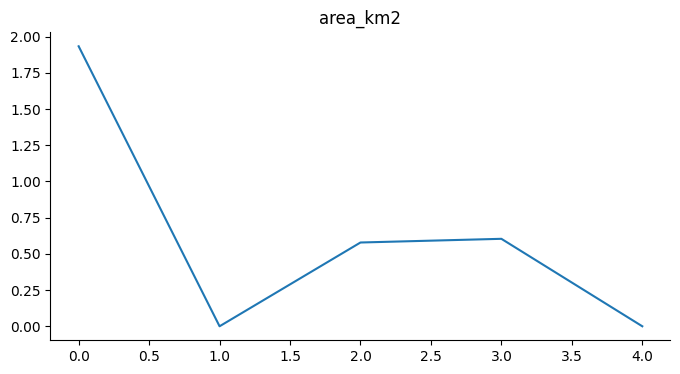

In [49]:
from matplotlib import pyplot as plt
_df_17['area_km2'].plot(kind='line', figsize=(8, 4), title='area_km2')
plt.gca().spines[['top', 'right']].set_visible(False)

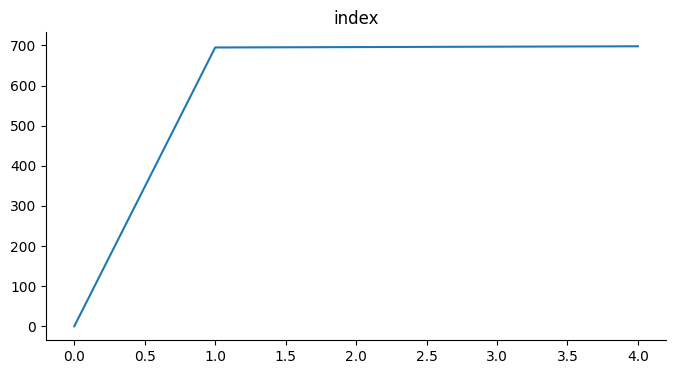

In [50]:
from matplotlib import pyplot as plt
_df_16['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

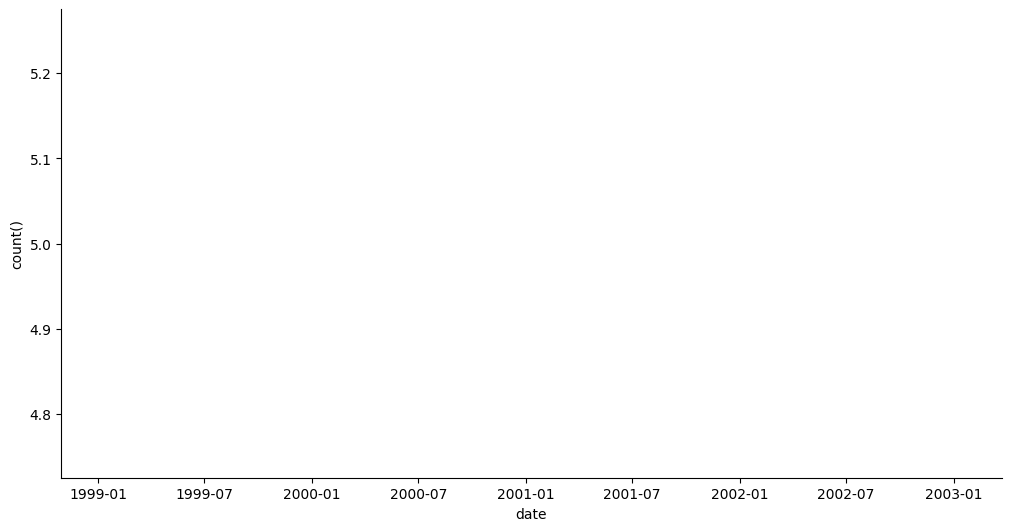

In [51]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

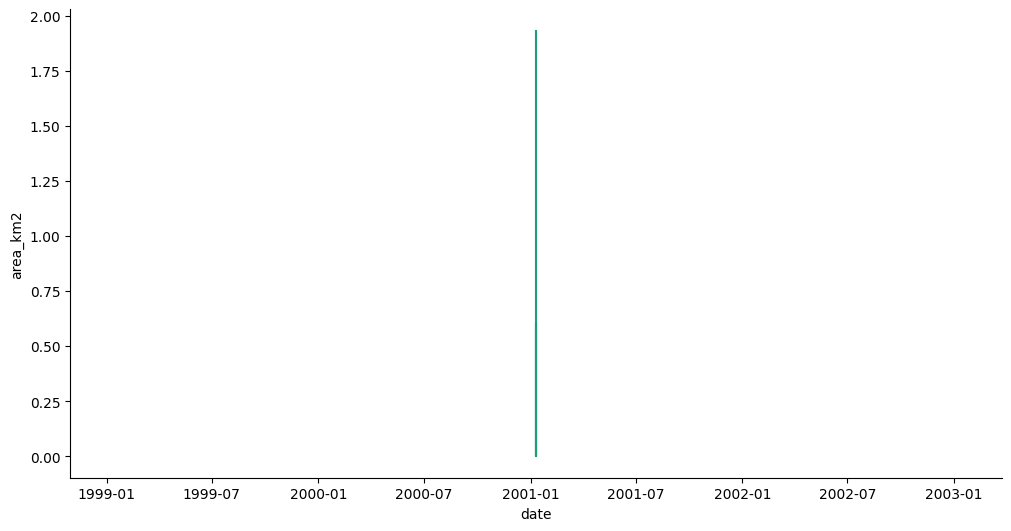

In [52]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['area_km2']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('area_km2')

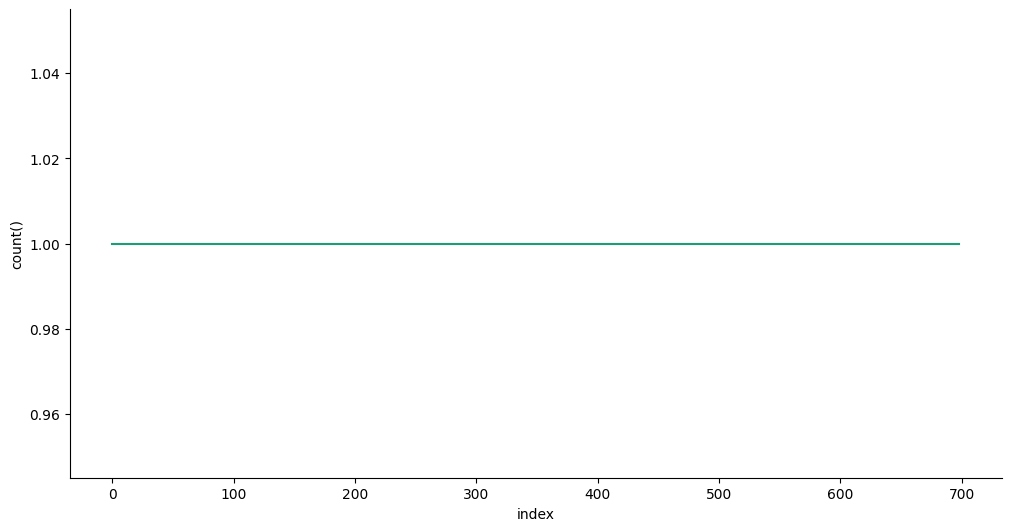

In [53]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

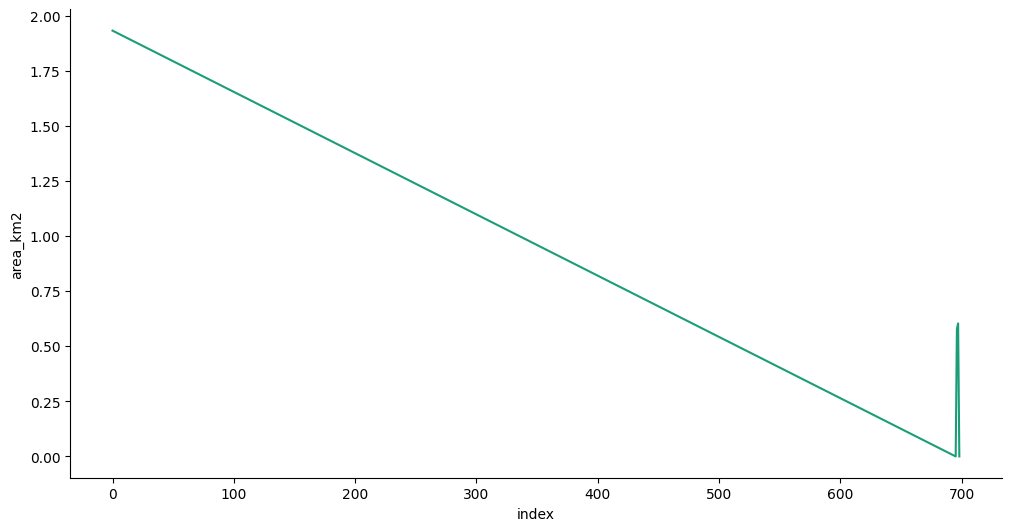

In [54]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['area_km2']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('area_km2')

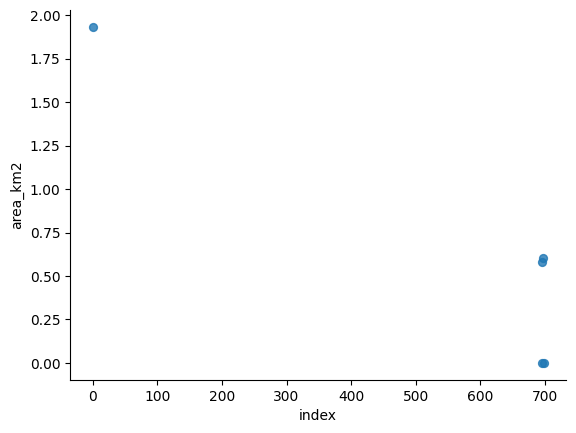

In [47]:
from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='index', y='area_km2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

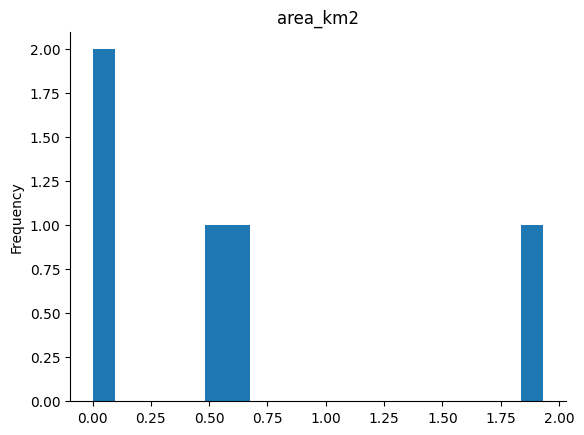

In [48]:
from matplotlib import pyplot as plt
_df_10['area_km2'].plot(kind='hist', bins=20, title='area_km2')
plt.gca().spines[['top', 'right',]].set_visible(False)

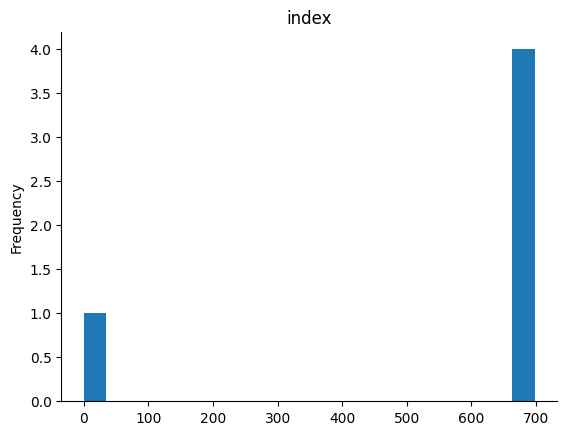

In [45]:
from matplotlib import pyplot as plt
_df_9['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [37]:
import pandas as pd

df = pd.DataFrame([f['properties'] for f in table.getInfo()['features']])

# Explicit date parsing
df['date'] = pd.to_datetime(df['date'])

df = df.sort_values('date')
df.head()

,area_km2,date
0,1.933499,2001-01-10
695,0.000000,2001-01-10
696,0.578480,2001-01-10
697,0.603972,2001-01-10
698,0.000000,2001-01-10


In [43]:
import pandas as pd

df = pd.DataFrame([f['properties'] for f in table.getInfo()['features']])

# Explicit date parsing
df['date'] = pd.to_datetime(df['date'])

df = df.sort_values('date')
df.head()

,area_km2,date
0,1.933499,2001-01-10
695,0.000000,2001-01-10
696,0.578480,2001-01-10
697,0.603972,2001-01-10
698,0.000000,2001-01-10


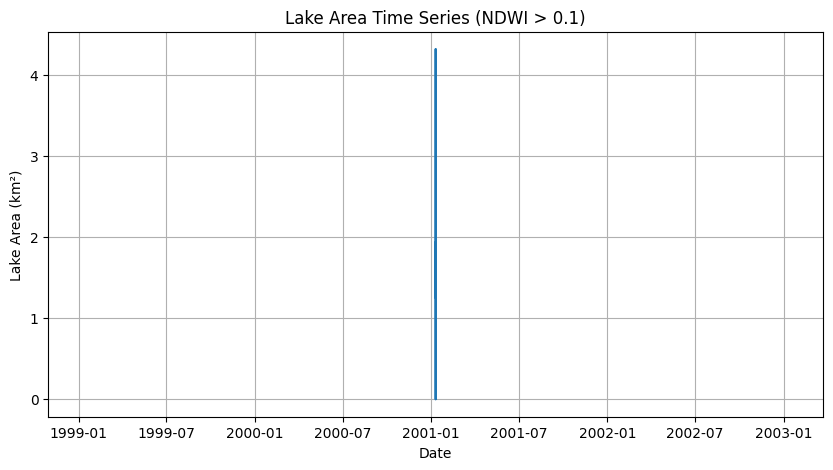

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df['date'], df['area_km2'])
plt.xlabel('Date')
plt.ylabel('Lake Area (km²)')
plt.title('Lake Area Time Series (NDWI > 0.1)')
plt.grid(True)
plt.show()